In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.optim import Adam
from tqdm.auto import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_transforms = transforms.Compose([transforms.ToTensor()])

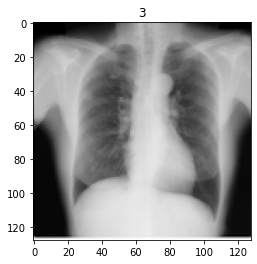

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root='../anomoly_detection/Directions01/train',transform=data_transforms)
test_dataset = torchvision.datasets.ImageFolder(root='../anomoly_detection/Directions01/test',transform=data_transforms)

i,l = train_dataset[900]
plt.imshow(i.permute(1,2,0))
plt.title(l)
plt.show()

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [6]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3,stride =2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3,stride =2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*8*8 ,64),
            nn.Linear(64,3)
        )
        
        self.decoder = nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.Linear(64, 128*8*8),
            torch.nn.Unflatten(-1, (128,8,8)),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec,enc




In [7]:

model = Autoencoder().to("cuda")
inputs = torch.randn(1,3,128, 128).to("cuda")
outputs,_ = model(inputs)
print(outputs.shape)
summary(model, (3,128, 128))

torch.Size([1, 3, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
           Flatten-9                 [-1, 8192]               0
           Linear-10                   [-1, 64]         524,352
           Linear-11                    [-1, 3]             195
           Linear-12                   [-1, 64]             256
           Linear-13                 [-1, 8192]         532,480
        Un

In [8]:
loss_fn = nn.L1Loss()
optimizer = Adam(model.parameters(),lr=0.001)

In [9]:
epochs = 30

for epoch in tqdm(range(epochs)):
    run_loss = 0
    for _, (image,label) in enumerate(train_dataloader):

        image , label  = image.to(device) , label.to(device)
        optimizer.zero_grad()
        
        output,_ = model(image)
        loss = loss_fn(output , image)
        run_loss += loss.item() * image.size(0)
        loss.backward()
        optimizer.step()
        
    print(f"epoch train loss : {run_loss/len(train_dataloader)}")
torch.save(model.state_dict(), "/home/akaniyar/anomoly_detection/epoch.pth")

  0%|          | 0/30 [00:00<?, ?it/s]

epoch train loss : 6.797900636990865
epoch train loss : 5.528058481216431
epoch train loss : 4.412407666444778
epoch train loss : 3.7625090956687925
epoch train loss : 3.4389370838801065
epoch train loss : 3.3300615270932514
epoch train loss : 3.2458911647399264
epoch train loss : 3.206014934182167
epoch train loss : 3.1150108138720194
epoch train loss : 3.075453688700994
epoch train loss : 3.027179816365242
epoch train loss : 3.002669037381808
epoch train loss : 2.9644992301861444
epoch train loss : 2.9597206582625706
epoch train loss : 2.905059149861336
epoch train loss : 2.8929987460374833
epoch train loss : 2.89262615442276
epoch train loss : 2.855058950185776
epoch train loss : 2.8296393622954685
epoch train loss : 2.8092630912860233
epoch train loss : 2.79710312585036
epoch train loss : 2.805568355321884
epoch train loss : 2.773090665539106
epoch train loss : 2.7706501017014187
epoch train loss : 2.7545364767313005
epoch train loss : 2.7601462254921594
epoch train loss : 2.721220

In [10]:
class_names = test_dataset.classes
train_label_mapping = {i: k for i,k in enumerate(class_names)}
train_label_mapping

{0: 'down', 1: 'left', 2: 'right', 3: 'up'}

In [11]:
encoded_imgs = []
checkpoint = torch.load("/home/akaniyar/anomoly_detection/epoch.pth")
model.load_state_dict(checkpoint)
model.eval()
train_labels = []
with torch.no_grad():
    for _,(image,labels) in enumerate(train_dataloader):
        images, labels = image.to(device) , labels.to(device)
        train_labels.extend(train_label_mapping[label.item()] for label in labels)
        _, encoded = model(images)
        encoded_imgs.append(encoded)
encoded_imgs = torch.cat(encoded_imgs, dim=0)
encoded_imgs = encoded_imgs.cpu().numpy()

print(encoded_imgs.shape)

(948, 3)


In [12]:
# Apply K-means clustering to features
kmeans = KMeans(n_clusters=4, n_init=20)
kmeans.fit(encoded_imgs)

# # Evaluate clustering performance
cluster_labels = kmeans.labels_

32


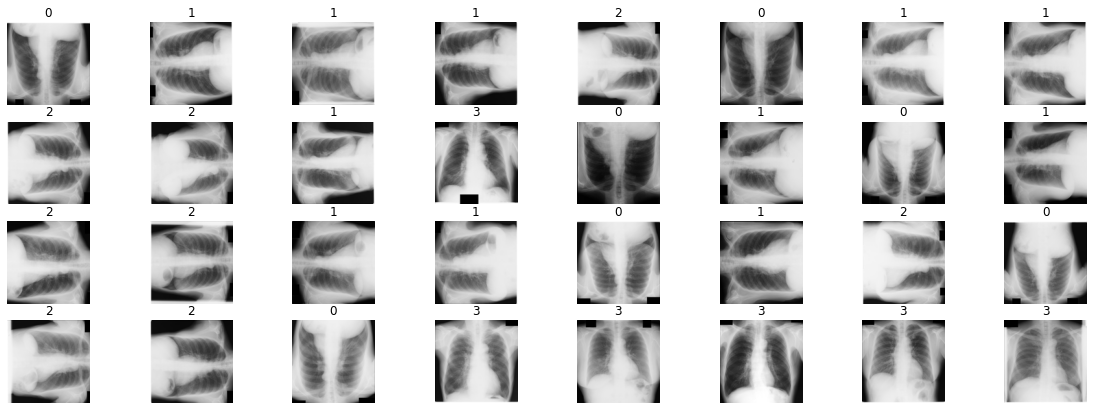

In [28]:
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(20, 7))


count = 0
with torch.inference_mode():
    for _,(image,labels) in enumerate(train_dataloader):
        images, labels = image.to(device) , labels.to(device)
        _, pred = model(images)
        predict = kmeans.predict(pred.cpu().numpy())
        print(len(images))
        rows, columns = 4, 8
        figure_location = 0
        for predi, image in zip(predict, images):
            figure_location += 1
            fig1.add_subplot(rows, columns, figure_location)  # type: ignore
            plt.title(predi)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            plt.axis(False);
            plt.savefig("train_kmeans_prediction_label.png",dpi=300)
        plt.show()
        count += 1
        if count == 1:
            break



In [19]:
mapping = {0: "down", 2: "right", 3: "up", 1: "left"}
pred_labels = [mapping[lbl] for lbl in cluster_labels]
count = 0
for pred, tr in zip(pred_labels, train_labels):
    count += pred == tr
count

948

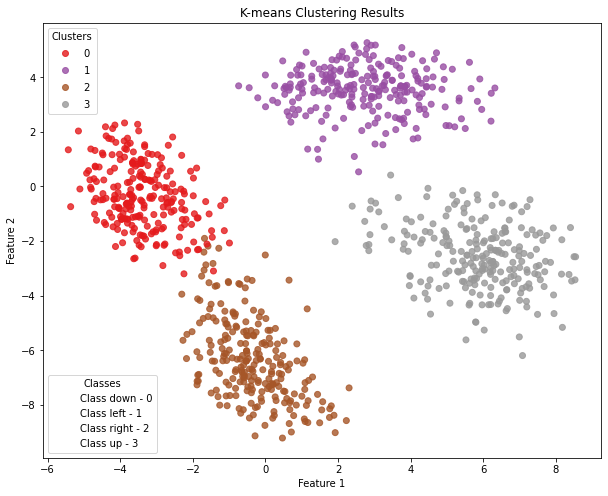

In [29]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 8))
for i in range(4):
    ax.scatter(encoded_imgs[(train_labels == i), 0], encoded_imgs[(train_labels == i), 1], c="white", label='Class '+ mapping[i] + " - " + str(i), alpha=0.5)
scatter = ax.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=cluster_labels, cmap='Set1', alpha=0.8)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
ax.add_artist(legend1)
legend2 = ax.legend(loc="lower left", title="Classes")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering Results')
plt.savefig("train_kmeans_results.png",dpi=300)
plt.show()


In [21]:
encoded_imgs_predict = []
labels_predict = []
count = 0

with torch.inference_mode():
    for _,(image,label) in enumerate(test_dataloader):
        images, labels = image.to(device) , label.to(device)
        labels_predict.extend(labels)
        _, encoded = model(images)
        prediction = kmeans.predict(encoded.cpu().numpy())
        encoded_imgs_predict.append(encoded)

encoded_imgs_predict = torch.cat(encoded_imgs_predict, dim=0)
encoded_imgs_predict = encoded_imgs_predict.cpu().numpy()

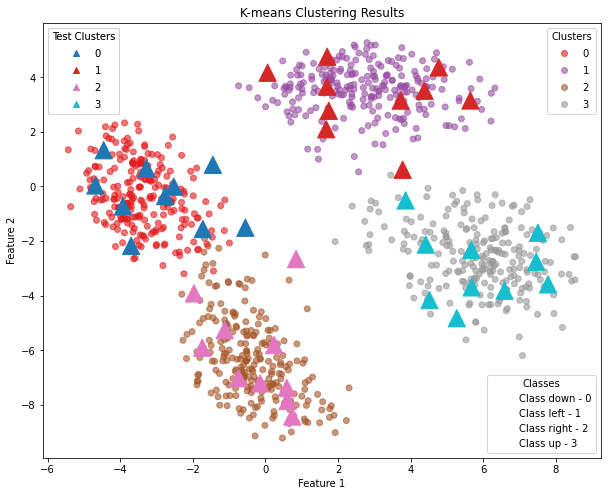

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(4):
    ax.scatter(encoded_imgs[(train_labels == i), 0], encoded_imgs[(train_labels == i), 1], c="white", label='Class '+ mapping[i] + " - " + str(i), alpha=0.5)
scatter = ax.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=cluster_labels, cmap='Set1', alpha=0.6)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)
legend2 = ax.legend(loc="lower right", title="Classes")
ax.add_artist(legend2)

prediction = kmeans.predict(encoded_imgs_predict)

scatter_2 = ax.scatter(
    encoded_imgs_predict[:, 0], encoded_imgs_predict[:, 1],
    c=prediction,
    cmap="tab10",
    s=300,
    marker="^",
    label="Prediction",
    alpha=1
)
legend3 = ax.legend(*scatter_2.legend_elements(), loc="upper left", title="Test Clusters")
ax.add_artist(legend3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering Results')
plt.savefig("test_kmeans_resultswithtrain.png",dpi=300)
plt.show()